In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tucgianqua/images - 2020-11-06T004105.719_face.png
/kaggle/input/tucgianqua/images - 2020-11-06T004103.441_face.png
/kaggle/input/tucgianqua/images - 2020-11-06T004104.970_face.png
/kaggle/input/tucgianqua/images - 2020-11-06T004104.367_face.png
/kaggle/input/tucgianqua/images - 2020-11-06T004103.784_face.png
/kaggle/input/tucgianqua/images - 2020-11-06T004106.793_face.png
/kaggle/input/tucgianqua/images - 2020-11-06T004106.315_face.png
/kaggle/input/tucgianqua/images - 2020-11-06T004107.142_face.png
/kaggle/input/khongcamxuc/379534524_f16e8b3fbd_n_face.png
/kaggle/input/khongcamxuc/422971195_9b7043c0e0_b_face.png
/kaggle/input/khongcamxuc/2Q__ (4)_face.png
/kaggle/input/khongcamxuc/379534527_984fcf635f_n_face.png
/kaggle/input/khongcamxuc/422971466_0eceb85655_b_face.png
/kaggle/input/khongcamxuc/350605554_1bff52bbef_n_face.png
/kaggle/input/khongcamxuc/2Q__ (7)_face.png
/kaggle/input/khongcamxuc/9k_ (8)_face.png
/kaggle/input/khongcamxuc/379534518_f6471f2810_b_face.png
/

In [2]:
# Import các thư viện sử dụng trong bài
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing import image
from PIL import UnidentifiedImageError
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight


import warnings
warnings.filterwarnings('ignore')

2024-06-12 14:36:18.763860: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-12 14:36:18.763966: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-12 14:36:18.880126: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<Axes: >

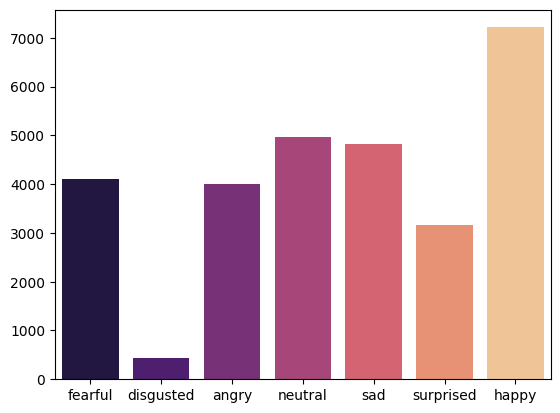

In [3]:
# Xây dựng đường dẫn tới thư mục chứa dữ liệu huấn luyện
train_dir = '/kaggle/input/emotion-detection-fer/train'

# Lấy danh sách các cảm xúc từ thư mục huấn luyện
emotions = os.listdir(train_dir)

# Đếm số lượng ảnh cho mỗi cảm xúc trong thư mục huấn luyện
train_counts = []
for emotion in emotions:
    folder = os.path.join(train_dir, emotion)
    train_counts.append(len(os.listdir(folder)))

# Vẽ biểu đồ cột thể hiện số lượng ảnh cho mỗi cảm xúc trong thư mục huấn luyện
sns.barplot(x=emotions, y=train_counts, palette='magma')

<Axes: >

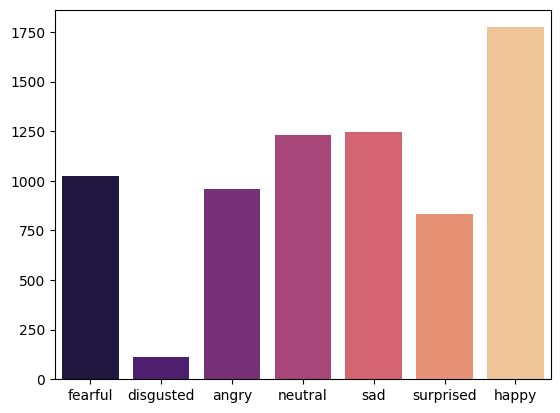

In [4]:
# Xây dựng đường dẫn tới thư mục chứa dữ liệu kiểm tra
test_dir = '/kaggle/input/emotion-detection-fer/test'

# Đếm số lượng ảnh cho mỗi cảm xúc trong thư mục kiểm tra
test_counts = []
for emotion in emotions:
    folder = os.path.join(test_dir, emotion)
    test_counts.append(len(os.listdir(folder)))

# Vẽ biểu đồ cột thể hiện số lượng ảnh cho mỗi cảm xúc trong thư mục kiểm tra
sns.barplot(x=emotions, y=test_counts, palette='magma')

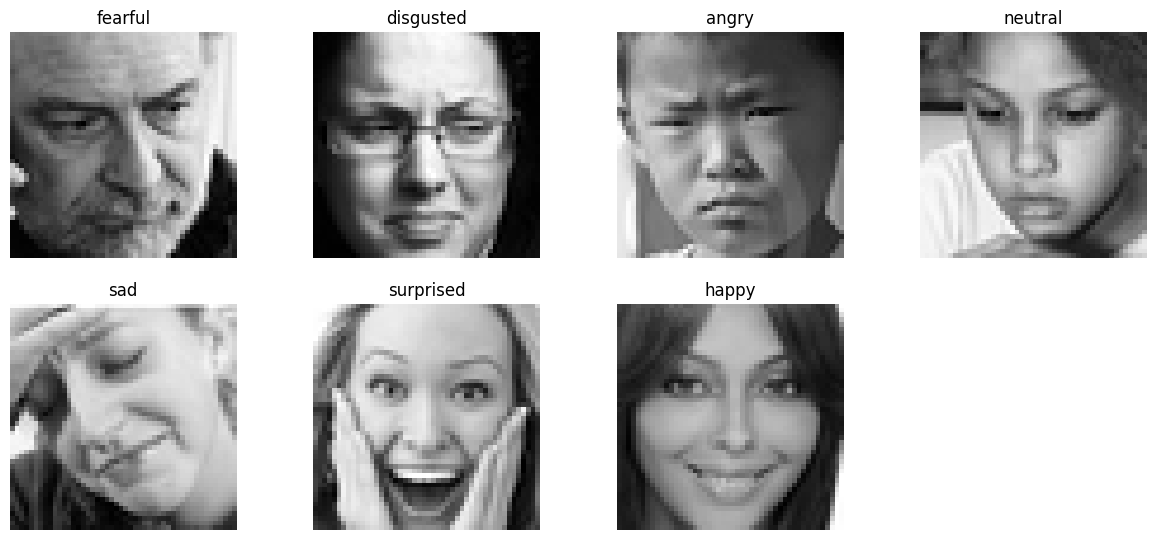

In [5]:
# Hiển thị một số ảnh mẫu từ thư mục huấn luyện
plt.figure(figsize=(15,10))

for i, emotion in enumerate(emotions, 1):
    folder = os.path.join(train_dir, emotion)
    img_path = os.path.join(folder, os.listdir(folder)[42])
    img = plt.imread(img_path)
    plt.subplot(3, 4, i)
    plt.imshow(img, cmap='gray')
    plt.title(emotion)
    plt.axis('off')

In [6]:
# Tạo các biến để tiền xử lý dữ liệu ảnh

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    rescale=1/255
)

# Tạo generator cho dữ liệu huấn luyện và kiểm tra
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [7]:
# Tính toán trọng số của các lớp dựa trên dữ liệu huấn luyện
classes = np.array(train_generator.classes)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(classes),
    y=classes
)

class_weights_dict = dict(enumerate(class_weights))
class_weights_dict


{0: 1.0266046844269623,
 1: 9.406618610747051,
 2: 1.0010460615781582,
 3: 0.5684387684387684,
 4: 0.8260394187886635,
 5: 0.8491274770777877,
 6: 1.293372978330405}

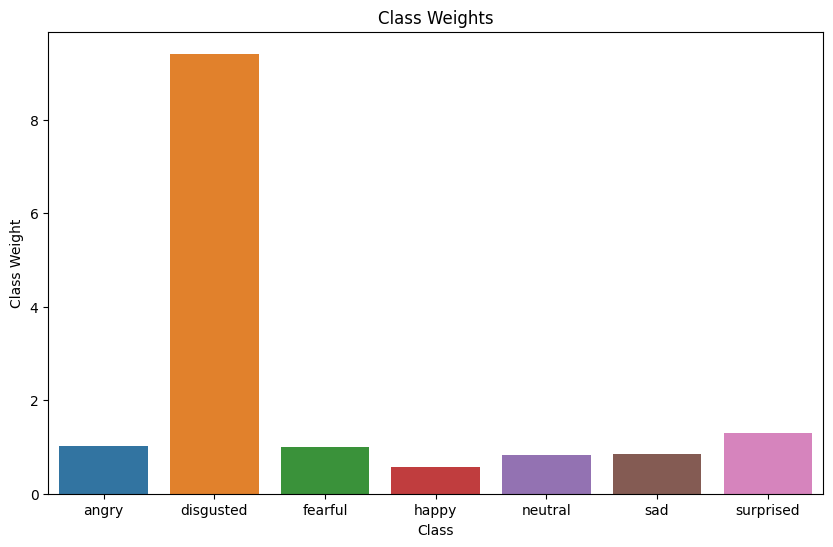

In [8]:
# Vẽ biểu đồ trọng số của các lớp
# Lấy tên các lớp từ train_generator
class_names = list(train_generator.class_indices.keys())
plt.figure(figsize=(10, 6))
sns.barplot(x=class_names, y=list(class_weights_dict.values()))
plt.xlabel('Class')
plt.ylabel('Class Weight')
plt.title('Class Weights')
plt.show()

In [9]:
# Xây dựng mô hình sử dụng kiến trúc ResNet50V2
input_shape = (224, 224, 3)  
base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=input_shape)
model = Sequential([
    base_model,
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.1),
    Dense(256, activation='relu'),
    Dropout(0.1),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(7, activation='softmax')
])

# Biên dịch mô hình
optimizer = Adamax(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ ?                      │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 23,519,360 (89.72 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [10]:
# Huấn luyện mô hình
train_history = model.fit(
    train_generator,
    steps_per_epoch=200,
    epochs=25,
    validation_data=test_generator,
    validation_steps=100,
    class_weight=class_weights_dict,
)

Epoch 1/25
  1/200 ━━━━━━━━━━━━━━━━━━━━ 3:44:33 68s/step - accuracy: 0.1875 - loss: 1.6964

I0000 00:00:1718203070.023117      83 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718203070.109382      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/step - accuracy: 0.1587 - loss: 1.9320

W0000 00:00:1718203209.841527      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


200/200 ━━━━━━━━━━━━━━━━━━━━ 228s 807ms/step - accuracy: 0.1588 - loss: 1.9319 - val_accuracy: 0.2797 - val_loss: 1.8560
Epoch 2/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 111s 559ms/step - accuracy: 0.2588 - loss: 1.7948 - val_accuracy: 0.3119 - val_loss: 1.7951
Epoch 3/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 95s 478ms/step - accuracy: 0.3068 - loss: 1.7786 - val_accuracy: 0.4036 - val_loss: 1.6305
Epoch 4/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 92s 461ms/step - accuracy: 0.3384 - loss: 1.7094 - val_accuracy: 0.4500 - val_loss: 1.5135
Epoch 5/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 207ms/step - accuracy: 0.3831 - loss: 1.6427 - val_accuracy: 0.4541 - val_loss: 1.4729
Epoch 6/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 89s 430ms/step - accuracy: 0.4076 - loss: 1.5923 - val_accuracy: 0.4769 - val_loss: 1.3742
Epoch 7/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 88s 442ms/step - accuracy: 0.4136 - loss: 1.5237 - val_accuracy: 0.4984 - val_loss: 1.3504
Epoch 8/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 84s 422ms/step - accuracy: 0.4096 - loss: 1.4881 - v

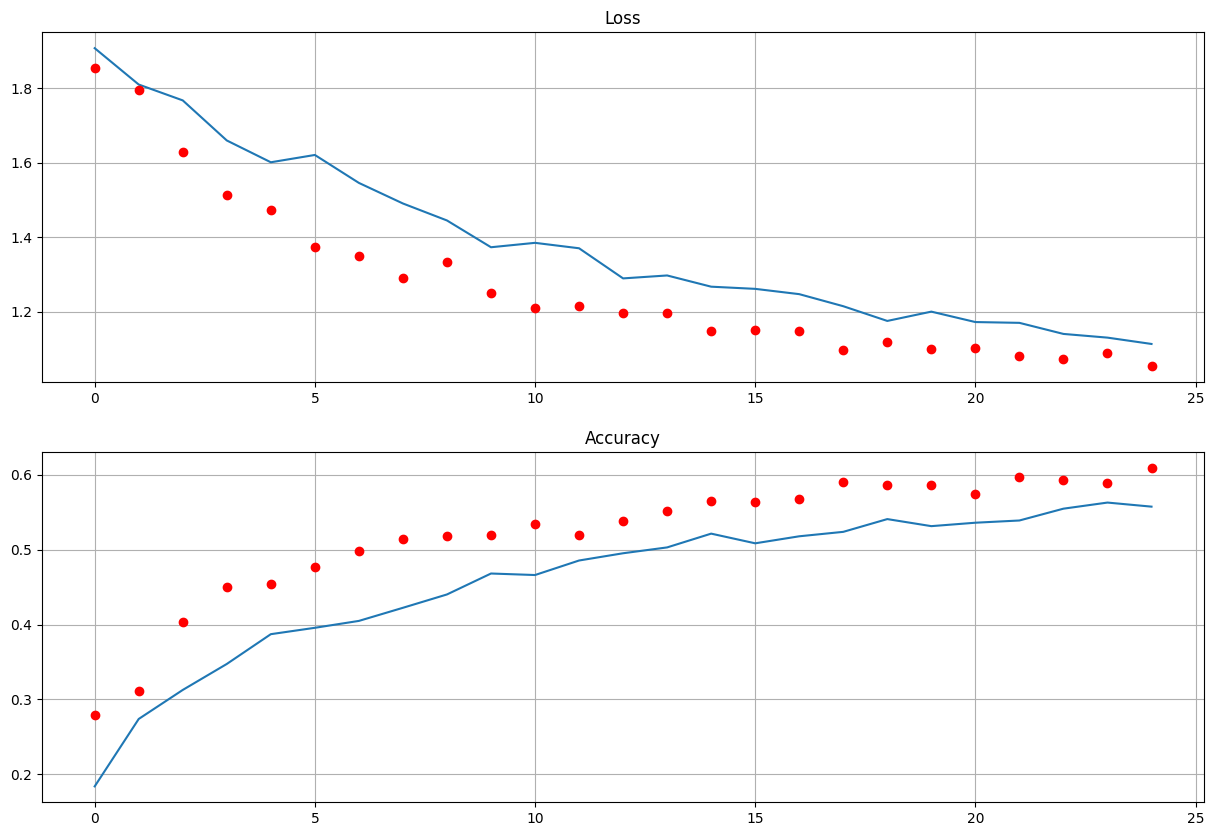

In [11]:
# Hiển thị đồ thị loss và accuracy của quá trình huấn luyện

plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'], 'ro')
plt.title('Loss')
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(train_history.history['accuracy'])
plt.plot(train_history.history['val_accuracy'], 'ro')
plt.title('Accuracy')
plt.grid(True)

In [12]:
# Tạo generator cho dữ liệu kiểm tra và tính toán ma trận confusion
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

true_labels = test_generator.classes
preds = model.predict(test_generator, steps=len(test_generator))
pred_labels = np.argmax(preds, axis=1)
classes=list(test_generator.class_indices.keys())

Found 7178 images belonging to 7 classes.
  4/225 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step

W0000 00:00:1718204960.591060      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


225/225 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step


In [13]:
print(classification_report(true_labels, pred_labels, target_names=classes))

              precision    recall  f1-score   support

       angry       0.51      0.47      0.49       958
   disgusted       0.39      0.68      0.49       111
     fearful       0.52      0.22      0.31      1024
       happy       0.86      0.81      0.84      1774
     neutral       0.51      0.70      0.59      1233
         sad       0.46      0.52      0.49      1247
   surprised       0.70      0.77      0.73       831

    accuracy                           0.60      7178
   macro avg       0.57      0.60      0.56      7178
weighted avg       0.61      0.60      0.60      7178



Text(0.5, 1.0, 'Confusion Matrix')

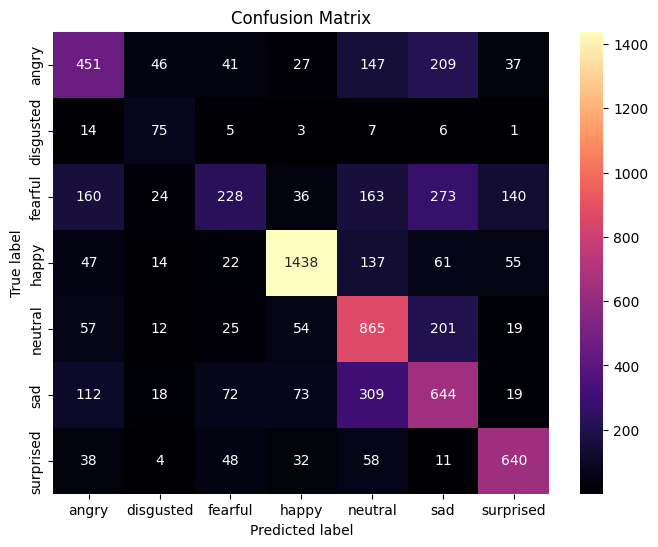

In [14]:
# Tính toán ma trận confusion
cm = confusion_matrix(true_labels, pred_labels)

# Hiển thị ma trận confusion dưới dạng heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="magma", xticklabels=classes, yticklabels=classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')

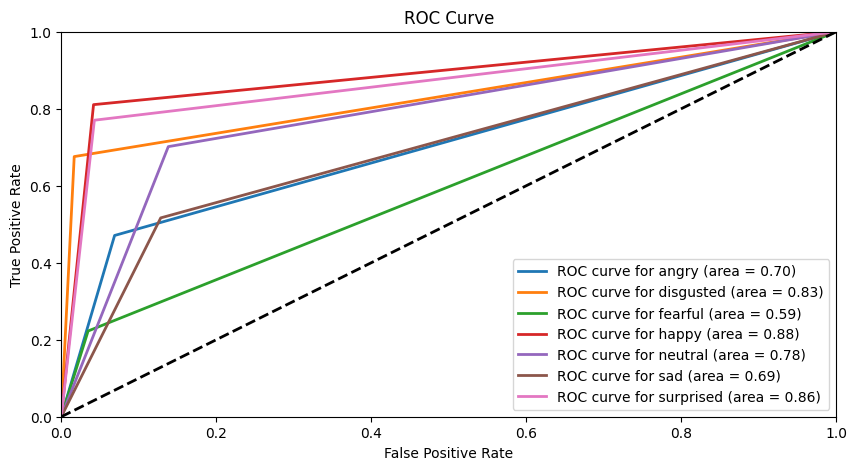

In [15]:
# One-hot encode nhãn thực tế và nhãn dự đoán để tính toán ROC curve và AUC
y_encoded = pd.get_dummies(true_labels).astype(int).values
preds_encoded = pd.get_dummies(pred_labels).astype(int).values

# Tính toán false positive rate (fpr), true positive rate (tpr) và area under the curve (AUC) cho từng lớp
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_encoded[:,i], preds_encoded[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Vẽ ROC curve và hiển thị AUC cho từng lớp
plt.figure(figsize=(10,5))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f"ROC curve for {classes[i]} (area = {roc_auc[i]:0.2f})")
    
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

In [16]:
# Lưu mô hình đã huấn luyện
model.save('EmotionDetector.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Ảnh: /kaggle/input/tucgianqua/images - 2020-11-06T004105.719_face.png - Cảm xúc dự đoán: angry
Ảnh: /kaggle/input/tucgianqua/images - 2020-11-06T004103.441_face.png - Cảm xúc dự đoán: disgusted
Ảnh: /kaggle/input/tucgianqua/images - 2020-11-06T004104.970_face.png - Cảm xúc dự đoán: angry
Ảnh: /kaggle/input/tucgianqua/images - 2020-11-06T004104.367_face.png - Cảm xúc dự đoán: angry
Ảnh: /kaggle/input/tucgianqua/images - 2020-11-06T004103.784_face.png - Cảm xúc dự đoán: angry
Ảnh: /kaggle/input/tucgianqua/images - 2020-11-06T004106.793_face.png - Cảm xúc dự đoán: disgusted
Ảnh: /kaggle/input/tucgianqua/images - 2020-11-06T004106.315_face.png - Cảm xúc dự đoán: neutral
Ảnh: /kaggle/input/tucg

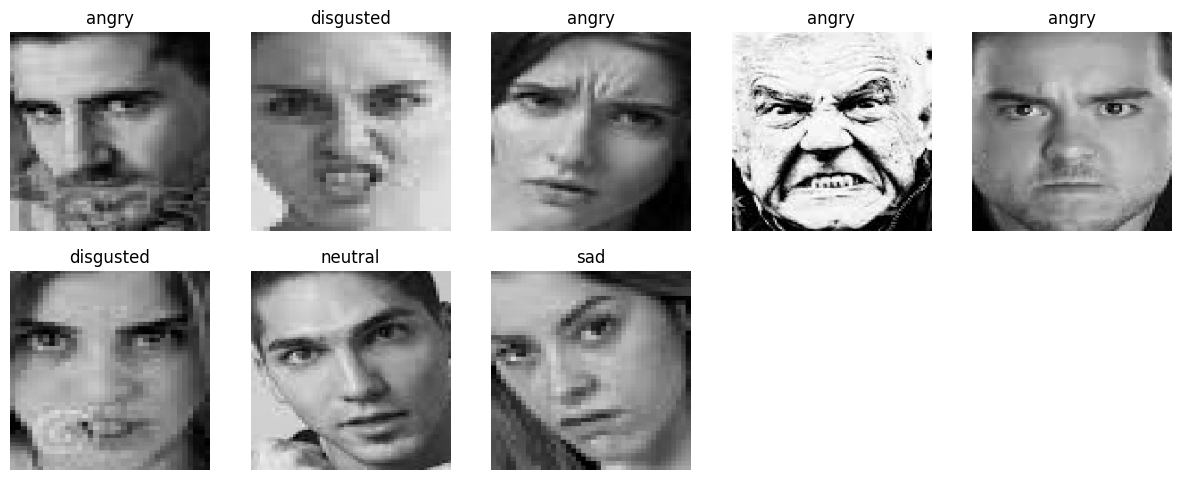

In [17]:
# Load mô hình tốt nhất đã được huấn luyện
best_model = model

# Xây dựng đường dẫn tới thư mục chứa các ảnh kiểm tra
test_dir = '/kaggle/input/tucgianqua'  # Thay đổi đường dẫn tới thư mục chứa các ảnh kiểm tra

# Define kích thước ảnh và các nhãn lớp
image_size = (224, 224)  
class_names = list(train_generator.class_indices.keys())

# Hàm dự đoán cảm xúc cho các ảnh kiểm tra
def classify_emotions(test_dir, model):
    test_images = [os.path.join(test_dir, fname) for fname in os.listdir(test_dir)]
    predictions = []
    
    for img_path in test_images:
        try:
            img = image.load_img(img_path, target_size=image_size)
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0) / 255.0  # Chuẩn hóa ảnh
            
            prediction = model.predict(img_array)
            predicted_class = class_names[np.argmax(prediction)]
            predictions.append((img_path, img, predicted_class))
        except UnidentifiedImageError:
            print(f"Không thể nhận dạng tệp ảnh {img_path}. Bỏ qua...")
        except Exception as e:
            print(f"Lỗi xử lý tệp {img_path}: {e}. Bỏ qua...")
    
    return predictions

# Dự đoán cảm xúc cho các ảnh kiểm tra
test_predictions = classify_emotions(test_dir, best_model)

# Hiển thị các ảnh với nhãn dự đoán tương ứng
def display_predictions(predictions):
    plt.figure(figsize=(15, 15))
    for i, (img_path, img, predicted_class) in enumerate(predictions):
        plt.subplot(5, 5, i + 1)
        plt.imshow(img)
        plt.title(predicted_class)
        plt.axis('off')
    plt.show()

# In các dự đoán và hiển thị ảnh với nhãn dự đoán
for img_path, img, predicted_class in test_predictions:
    print(f'Ảnh: {img_path} - Cảm xúc dự đoán: {predicted_class}')

display_predictions(test_predictions)